In [1]:
import os, sys
import h5py
import numpy as np
from numpy import genfromtxt
import nibabel as nb
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from nibabel.freesurfer.io import read_geometry
from nilearn.plotting.surf_plotting import load_surf_data
from nilearn.plotting.surf_plotting import load_surf_mesh
from brainspace.gradient import GradientMaps
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
from brainspace.datasets import load_conte69
from brainspace.null_models import SpinPermutations
import hcp_utils
# in house modules from the repo:
import plot_funcs                                
from plot_funcs import make_spider_rvalues           


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


### read-in hippocampal-cortical functional connectivity matrix

In [2]:
gdir = outdir = '../data/tout_group/'

fcfile = os.path.join(gdir, 'Hmean709_FC_left.h5')
f = h5py.File(fcfile, 'r')
fcon_LSUB = np.array(f['data'][0:1024,:])
fcon_LCA  = np.array(f['data'][1024:1024+2048,:])
fcon_LDG  = np.array(f['data'][1024+2048:1024+1024+2048,:])



### read-in hippocampal fused gradients

In [3]:
ddir = '../data/tout_group/'

# read-in primary and seconardy fusion gradients (G1 & G2) 
h  = h5py.File(os.path.join(ddir, 'Hmean709fusedGradients_left.h5'), 'r');
data = np.array(h['data'])


G1_fus_LSUB = data[0:1024,0]
G1_fus_LCA  = data[1024:1024+2048,0]
G1_fus_LDG  = data[1024+2048:1024+2048+1024,0]

G2_fus_LSUB = data[0:1024,1]
G2_fus_LCA  = data[1024:1024+2048,1]
G2_fus_LDG  = data[1024+2048:1024+2048+1024,1]

## projections of G1 (fus) on the cortical functional connectivity

In [4]:
# correlations between G1 (fused) of subfields and functional connectivity to the iscocortex

r1_LSUB = np.zeros((360,))
r1_LCA  = np.zeros((360,))
r1_LDG = np.zeros((360,))

for k in range(0, 360):
    r1_LSUB[k] = np.corrcoef(fcon_LSUB.T[k,:], G1_fus_LSUB)[-1:,:-1][0,0]
    r1_LCA[k]  = np.corrcoef(fcon_LCA.T[k,:], G1_fus_LCA)[-1:,:-1][0,0]
    r1_LDG[k]  = np.corrcoef(fcon_LDG.T[k,:], G1_fus_LDG)[-1:,:-1][0,0]

# correlations between G2 (fused) of subfields and functional connectivity to the iscocortex

r2_LSUB = np.zeros((360,))
r2_LCA  = np.zeros((360,))
r2_LDG = np.zeros((360,))

for k in range(0, 360):
    r2_LSUB[k] = np.corrcoef(fcon_LSUB.T[k,:], G2_fus_LSUB)[-1:,:-1][0,0]
    r2_LCA[k]  = np.corrcoef(fcon_LCA.T[k,:], G2_fus_LCA)[-1:,:-1][0,0]
    r2_LDG[k]  = np.corrcoef(fcon_LDG.T[k,:], G2_fus_LDG)[-1:,:-1][0,0]

In [5]:
r1_LSUB.min(), r1_LSUB.max()

(-0.47738550853298833, 0.8835000009453005)

### load surfaces & do the labeling & plot

In [6]:
# load surfaces
surf_lh, surf_rh = load_conte69()

# load labeling file
labeling_file = '../data/tout_group/glasser.csv' 
labeling = genfromtxt(labeling_file)

mask = labeling != 0 # this takes the mask of the left hem only..

mymask = np.ones((64984,)).astype('bool')
mymask[np.where(mask == False)[0]] = False
mymask[np.where(mask == False)[0] + 32492] = False


In [7]:
# map r-values to the isocortex

r1_LSUB_labeled = map_to_labels(r1_LSUB, labeling, mask=mymask) 
r1_LSUB_labeled[np.where(mymask == False)] = np.nan

r1_LCA_labeled = map_to_labels(r1_LCA, labeling, mask=mymask) 
r1_LCA_labeled[np.where(mymask == False)] = np.nan


r1_LDG_labeled = map_to_labels(r1_LDG, labeling, mask=mymask) 
r1_LDG_labeled[np.where(mymask == False)] = np.nan


r2_LSUB_labeled = map_to_labels(r2_LSUB, labeling, mask=mymask) 
r2_LSUB_labeled[np.where(mymask == False)] = np.nan

r2_LCA_labeled = map_to_labels(r2_LCA, labeling, mask=mymask) 
r2_LCA_labeled[np.where(mymask == False)] = np.nan


r2_LDG_labeled = map_to_labels(r2_LDG, labeling, mask=mymask) 
r2_LDG_labeled[np.where(mymask == False)] = np.nan

## SUB (left)

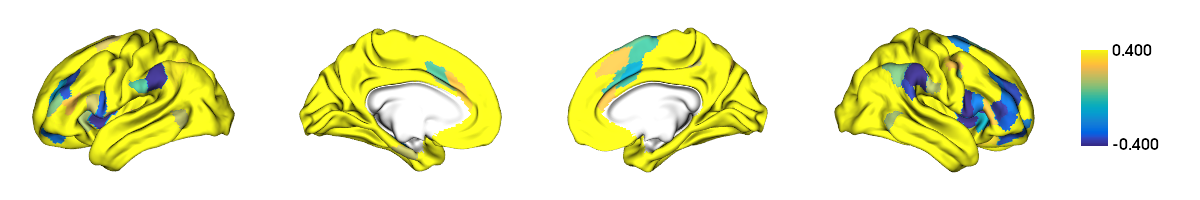

In [8]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r1_LSUB_labeled,
                 nan_color = (0.9,0.9,0.9,1), size = (1200, 200), cmap = plot_funcs.parula_cmap(),
                 color_bar = True, color_range = (-0.4, 0.4),
                 interactive = False, zoom = 1.3, embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/fusion_G1_cortex_lsub.svg'
                 )

# CA (left)

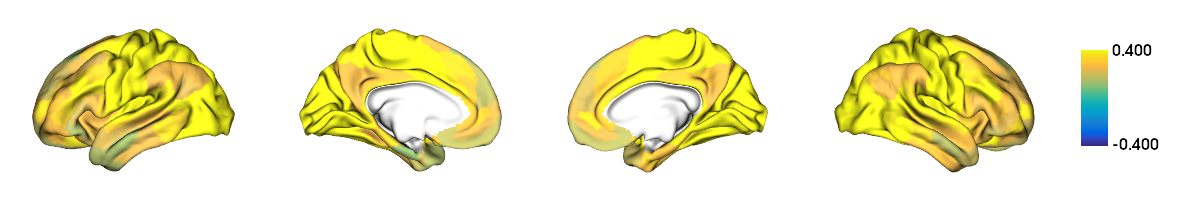

In [9]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r1_LCA_labeled,
                 nan_color = (0.9,0.9,0.9,1), size = (1200, 200), cmap = plot_funcs.parula_cmap(),
                 color_bar = True, color_range = (-0.4, 0.4),
                 interactive = False, zoom = 1.3, embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/fusion_G1_cortex_lca.svg'
                 )

## DG (left)

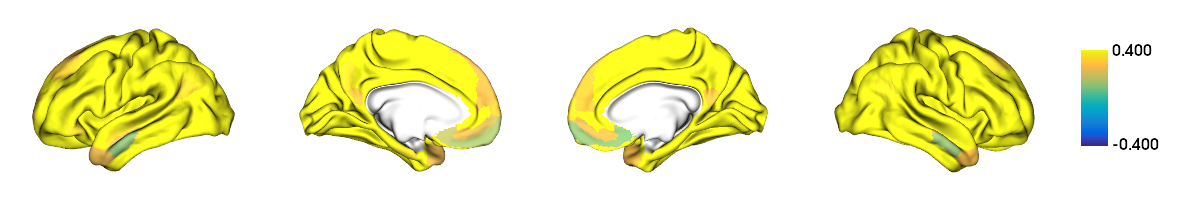

In [10]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r1_LDG_labeled,
                 nan_color = (0.9,0.9,0.9,1), size = (1200, 200), cmap = plot_funcs.parula_cmap(),
                 color_bar = True, color_range = (-0.4, 0.4),
                 interactive = False, zoom = 1.3, embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/fusion_G1_cortex_ldg.svg'
                 )                 

## projections of G2 (fus) on the cortical functional connectivity

In [11]:
# correlations between G2 (fused) of subfields and functional connectivity to the iscocortex

r2_LSUB = np.zeros((360,))
r2_LCA  = np.zeros((360,))
r2_LDG = np.zeros((360,))

for k in range(0, 360):
    r2_LSUB[k] = np.corrcoef(fcon_LSUB.T[k,:], G2_fus_LSUB)[-1:,:-1][0,0]
    r2_LCA[k]  = np.corrcoef(fcon_LCA.T[k,:], G2_fus_LCA)[-1:,:-1][0,0]
    r2_LDG[k]  = np.corrcoef(fcon_LDG.T[k,:], G2_fus_LDG)[-1:,:-1][0,0]

In [12]:
r2_LSUB.min(), r2_LSUB.max()

(-0.7934580494336524, 0.8927211783242585)

In [13]:
# map r-values to the isocortex
r2_LSUB_labeled = map_to_labels(r2_LSUB, labeling, mask=mymask) 
r2_LSUB_labeled[np.where(mymask == False)] = np.nan

r2_LCA_labeled = map_to_labels(r2_LCA, labeling, mask=mymask) 
r2_LCA_labeled[np.where(mymask == False)] = np.nan

r2_LDG_labeled = map_to_labels(r2_LDG, labeling, mask=mymask) 
r2_LDG_labeled[np.where(mymask == False)] = np.nan

### SUB (left)

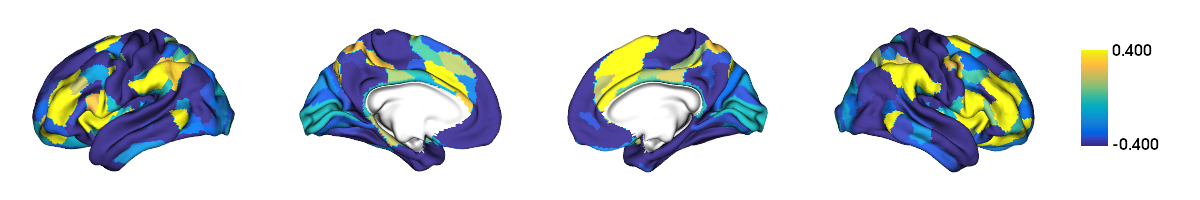

In [14]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r2_LSUB_labeled,
                 nan_color = (0.9,0.9,0.9,1), size = (1200, 200), cmap = plot_funcs.parula_cmap(),
                 color_bar = True, color_range = (-0.4, 0.4),
                 interactive = False, zoom = 1.3, embed_nb = True,                 
                 #screenshot = True,
                 #filename = '../figures/fusion_G2_cortex_lsub.svg'   
                )

### CA (left)

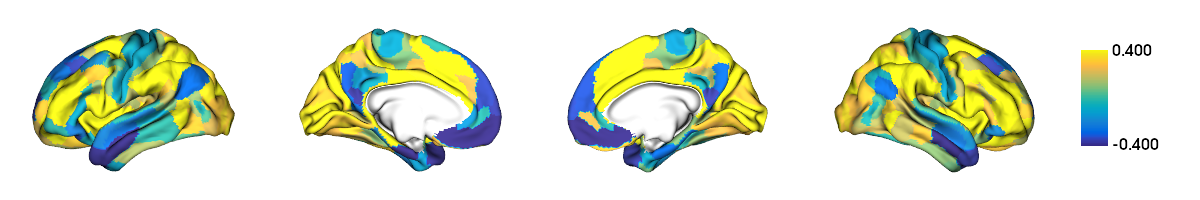

In [15]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r2_LCA_labeled,
                 nan_color = (0.9,0.9,0.9,1), size = (1200, 200), cmap = plot_funcs.parula_cmap(),
                 color_bar = True, color_range = (-0.4, 0.4),
                 interactive = False, zoom = 1.3, embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/fusion_G2_cortex_lca.svg'                   
                )

### DG (left)

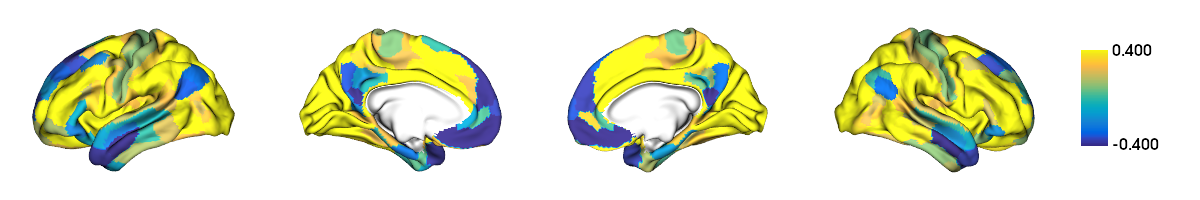

In [16]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r2_LDG_labeled,
                 nan_color = (0.9,0.9,0.9,1), size = (1200, 200), cmap = plot_funcs.parula_cmap(),
                 color_bar = True, color_range = (-0.4, 0.4),
                 interactive = False, zoom = 1.3, embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/fusion_G2_cortex_ldg.svg'                   
                )

## parcellate positive (top) and negative (down) correlations into Yeo-Krienen

In [17]:
yeo_L_file = '../data/tout_group/lh.Yeo2011_7Networks_N1000_32k.label.gii'
yeo_R_file = '../data/tout_group/rh.Yeo2011_7Networks_N1000_32k.label.gii'

yeo_L = nb.load(yeo_L_file).agg_data()
yeo_R = nb.load(yeo_R_file).agg_data()

yeo = np.concatenate((yeo_L, yeo_R))

yeo.shape

(64984,)

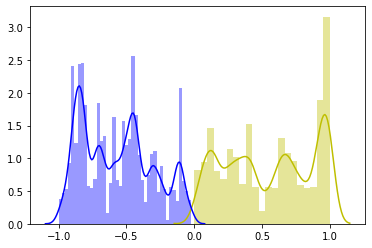

In [18]:
t2_LSUB = r2_LSUB_labeled.copy()
t2_LSUB = np.interp(t2_LSUB, (np.nanmin(t2_LSUB), np.nanmax(t2_LSUB)), (-1, 1))

t2_LSUB_top = t2_LSUB.copy()
t2_LSUB_dow = t2_LSUB.copy()

t2_LSUB_top[t2_LSUB_top < 0] = np.nan
t2_LSUB_dow[t2_LSUB_dow > 0] = np.nan

sns.distplot(t2_LSUB_top, color='y')
sns.distplot(t2_LSUB_dow, color='b')

### for posterior subiculum (yellow portions along G2 (fused) )

In [19]:
Y1_t2_LSUB_top = t2_LSUB_top[np.where(yeo==1)[0]]
Y2_t2_LSUB_top = t2_LSUB_top[np.where(yeo==2)[0]]
Y3_t2_LSUB_top = t2_LSUB_top[np.where(yeo==3)[0]]
Y4_t2_LSUB_top = t2_LSUB_top[np.where(yeo==4)[0]]
Y5_t2_LSUB_top = t2_LSUB_top[np.where(yeo==5)[0]]
Y6_t2_LSUB_top = t2_LSUB_top[np.where(yeo==6)[0]]
Y7_t2_LSUB_top = t2_LSUB_top[np.where(yeo==7)[0]]

### for anterior subiculum (blue portions along G2 (fused) )

In [20]:
Y1_t2_LSUB_dow = t2_LSUB_dow[np.where(yeo==1)[0]]
Y2_t2_LSUB_dow = t2_LSUB_dow[np.where(yeo==2)[0]]
Y3_t2_LSUB_dow = t2_LSUB_dow[np.where(yeo==3)[0]]
Y4_t2_LSUB_dow = t2_LSUB_dow[np.where(yeo==4)[0]]
Y5_t2_LSUB_dow = t2_LSUB_dow[np.where(yeo==5)[0]]
Y6_t2_LSUB_dow = t2_LSUB_dow[np.where(yeo==6)[0]]
Y7_t2_LSUB_dow = t2_LSUB_dow[np.where(yeo==7)[0]]


In [21]:
df_LSUB = pd.DataFrame(index  = ['top', 'down'], 
                       columns = ['yeo1', 'yeo2', 'yeo3',
                                'yeo4', 'yeo5', 'yeo6', 'yeo7'])

df_LSUB.at['top', 'yeo1'] = np.nanmean(Y1_t2_LSUB_top)
df_LSUB.at['top', 'yeo2'] = np.nanmean(Y2_t2_LSUB_top)
df_LSUB.at['top', 'yeo3'] = np.nanmean(Y3_t2_LSUB_top)
df_LSUB.at['top', 'yeo4'] = np.nanmean(Y4_t2_LSUB_top)
df_LSUB.at['top', 'yeo5'] = np.nanmean(Y5_t2_LSUB_top)
df_LSUB.at['top', 'yeo6'] = np.nanmean(Y6_t2_LSUB_top)
df_LSUB.at['top', 'yeo7'] = np.nanmean(Y7_t2_LSUB_top)

df_LSUB.at['down', 'yeo1'] = -1 * np.nanmean(Y1_t2_LSUB_dow)
df_LSUB.at['down', 'yeo2'] = -1 * np.nanmean(Y2_t2_LSUB_dow)
df_LSUB.at['down', 'yeo3'] = -1 * np.nanmean(Y3_t2_LSUB_dow)
df_LSUB.at['down', 'yeo4'] = -1 * np.nanmean(Y4_t2_LSUB_dow)
df_LSUB.at['down', 'yeo5'] = -1 * np.nanmean(Y5_t2_LSUB_dow)
df_LSUB.at['down', 'yeo6'] = -1 * np.nanmean(Y6_t2_LSUB_dow)
df_LSUB.at['down', 'yeo7'] = -1 * np.nanmean(Y7_t2_LSUB_dow)

df_LSUB

,yeo1,yeo2,yeo3,yeo4,yeo5,yeo6,yeo7
top,0.229311,0.34464,0.348564,0.682027,0.549208,0.647992,0.329649
down,0.404071,0.706465,0.430457,0.286796,0.650176,0.354076,0.668215


In [22]:
dfA = pd.DataFrame({'group': df_LSUB.columns,
                   'var1':   df_LSUB.loc['top'],
                   'var2':   df_LSUB.loc['down'] })


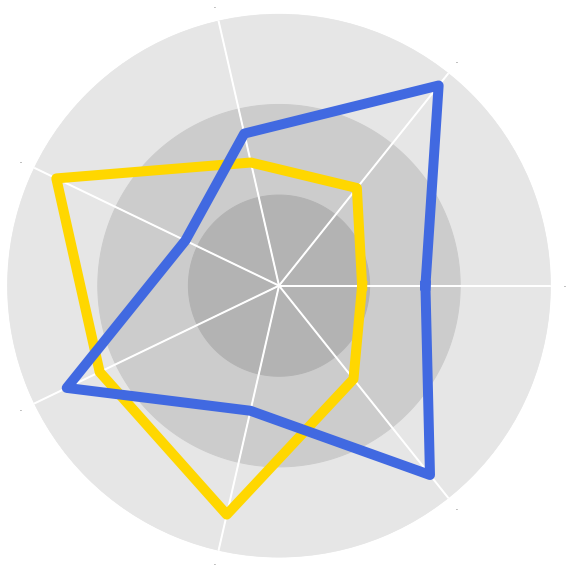

In [23]:
fig = make_spider_rvalues(dfA, 'var1', 'var2')

#fig.savefig('../figures/G2_fus_spyder_lsub.svg', dpi=300)

## CA (left)

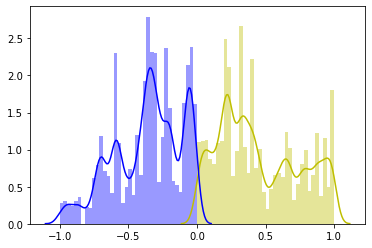

In [24]:
t2_LCA = r2_LCA_labeled.copy()
t2_LCA = np.interp(t2_LCA, (np.nanmin(t2_LCA), np.nanmax(t2_LCA)), (-1, 1))

t2_LCA_top = t2_LCA.copy()
t2_LCA_dow = t2_LCA.copy()

t2_LCA_top[t2_LCA_top < 0] = np.nan
t2_LCA_dow[t2_LCA_dow > 0] = np.nan

sns.distplot(t2_LCA_top, color='y')
sns.distplot(t2_LCA_dow, color='b')

In [25]:
Y1_t2_LCA_top = t2_LCA_top[np.where(yeo==1)[0]]
Y2_t2_LCA_top = t2_LCA_top[np.where(yeo==2)[0]]
Y3_t2_LCA_top = t2_LCA_top[np.where(yeo==3)[0]]
Y4_t2_LCA_top = t2_LCA_top[np.where(yeo==4)[0]]
Y5_t2_LCA_top = t2_LCA_top[np.where(yeo==5)[0]]
Y6_t2_LCA_top = t2_LCA_top[np.where(yeo==6)[0]]
Y7_t2_LCA_top = t2_LCA_top[np.where(yeo==7)[0]]


Y1_t2_LCA_dow = t2_LCA_dow[np.where(yeo==1)[0]]
Y2_t2_LCA_dow = t2_LCA_dow[np.where(yeo==2)[0]]
Y3_t2_LCA_dow = t2_LCA_dow[np.where(yeo==3)[0]]
Y4_t2_LCA_dow = t2_LCA_dow[np.where(yeo==4)[0]]
Y5_t2_LCA_dow = t2_LCA_dow[np.where(yeo==5)[0]]
Y6_t2_LCA_dow = t2_LCA_dow[np.where(yeo==6)[0]]
Y7_t2_LCA_dow = t2_LCA_dow[np.where(yeo==7)[0]]


df_LCA = pd.DataFrame(index  = ['top', 'down'], 
                       columns = ['yeo1', 'yeo2', 'yeo3',
                                'yeo4', 'yeo5', 'yeo6', 'yeo7'])

df_LCA.at['top', 'yeo1'] = np.nanmean(Y1_t2_LCA_top)
df_LCA.at['top', 'yeo2'] = np.nanmean(Y2_t2_LCA_top)
df_LCA.at['top', 'yeo3'] = np.nanmean(Y3_t2_LCA_top)
df_LCA.at['top', 'yeo4'] = np.nanmean(Y4_t2_LCA_top)
df_LCA.at['top', 'yeo5'] = np.nanmean(Y5_t2_LCA_top)
df_LCA.at['top', 'yeo6'] = np.nanmean(Y6_t2_LCA_top)
df_LCA.at['top', 'yeo7'] = np.nanmean(Y7_t2_LCA_top)

df_LCA.at['down', 'yeo1'] = -1 * np.nanmean(Y1_t2_LCA_dow)
df_LCA.at['down', 'yeo2'] = -1 * np.nanmean(Y2_t2_LCA_dow)
df_LCA.at['down', 'yeo3'] = -1 * np.nanmean(Y3_t2_LCA_dow)
df_LCA.at['down', 'yeo4'] = -1 * np.nanmean(Y4_t2_LCA_dow)
df_LCA.at['down', 'yeo5'] = -1 * np.nanmean(Y5_t2_LCA_dow)
df_LCA.at['down', 'yeo6'] = -1 * np.nanmean(Y6_t2_LCA_dow)
df_LCA.at['down', 'yeo7'] = -1 * np.nanmean(Y7_t2_LCA_dow)

df_LCA

dfB = pd.DataFrame({'group': df_LCA.columns,
                   'var1':   df_LCA.loc['top'],
                   'var2':   df_LCA.loc['down'] })

dfB


,group,var1,var2
yeo1,yeo1,0.259715,0.224574
yeo2,yeo2,0.203754,0.235379
yeo3,yeo3,0.475954,0.131862
yeo4,yeo4,0.663763,0.0887131
yeo5,yeo5,0.262101,0.523193
yeo6,yeo6,0.625991,0.203308
yeo7,yeo7,0.379629,0.49881


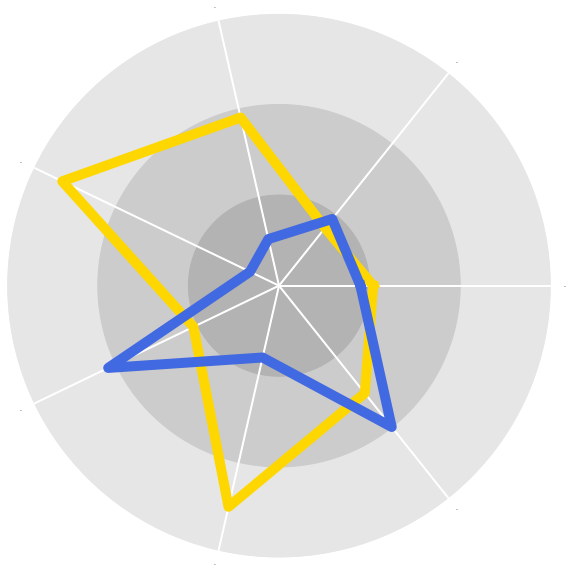

In [26]:
fig = make_spider_rvalues(dfB, 'var1', 'var2')

#fig.savefig('../figures/G2_fus_spyder_lca.svg', dpi=300)

## DG (left)

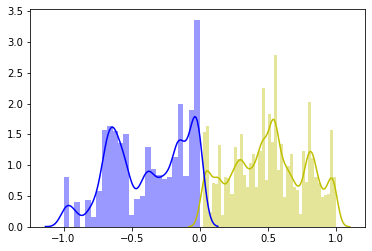

In [27]:
t2_LDG = r2_LDG_labeled.copy()
t2_LDG = np.interp(t2_LDG, (np.nanmin(t2_LDG), np.nanmax(t2_LDG)), (-1, 1))

t2_LDG_top = t2_LDG.copy()
t2_LDG_dow = t2_LDG.copy()

t2_LDG_top[t2_LDG_top < 0] = np.nan
t2_LDG_dow[t2_LDG_dow > 0] = np.nan

sns.distplot(t2_LDG_top, color='y')
sns.distplot(t2_LDG_dow, color='b')

In [28]:
Y1_t2_LDG_top = t2_LDG_top[np.where(yeo==1)[0]]
Y2_t2_LDG_top = t2_LDG_top[np.where(yeo==2)[0]]
Y3_t2_LDG_top = t2_LDG_top[np.where(yeo==3)[0]]
Y4_t2_LDG_top = t2_LDG_top[np.where(yeo==4)[0]]
Y5_t2_LDG_top = t2_LDG_top[np.where(yeo==5)[0]]
Y6_t2_LDG_top = t2_LDG_top[np.where(yeo==6)[0]]
Y7_t2_LDG_top = t2_LDG_top[np.where(yeo==7)[0]]


Y1_t2_LDG_dow = t2_LDG_dow[np.where(yeo==1)[0]]
Y2_t2_LDG_dow = t2_LDG_dow[np.where(yeo==2)[0]]
Y3_t2_LDG_dow = t2_LDG_dow[np.where(yeo==3)[0]]
Y4_t2_LDG_dow = t2_LDG_dow[np.where(yeo==4)[0]]
Y5_t2_LDG_dow = t2_LDG_dow[np.where(yeo==5)[0]]
Y6_t2_LDG_dow = t2_LDG_dow[np.where(yeo==6)[0]]
Y7_t2_LDG_dow = t2_LDG_dow[np.where(yeo==7)[0]]


df_LDG = pd.DataFrame(index  = ['top', 'down'], 
                       columns = ['yeo1', 'yeo2', 'yeo3',
                                'yeo4', 'yeo5', 'yeo6', 'yeo7'])

df_LDG.at['top', 'yeo1'] = np.nanmean(Y1_t2_LDG_top)
df_LDG.at['top', 'yeo2'] = np.nanmean(Y2_t2_LDG_top)
df_LDG.at['top', 'yeo3'] = np.nanmean(Y3_t2_LDG_top)
df_LDG.at['top', 'yeo4'] = np.nanmean(Y4_t2_LDG_top)
df_LDG.at['top', 'yeo5'] = np.nanmean(Y5_t2_LDG_top)
df_LDG.at['top', 'yeo6'] = np.nanmean(Y6_t2_LDG_top)
df_LDG.at['top', 'yeo7'] = np.nanmean(Y7_t2_LDG_top)

df_LDG.at['down', 'yeo1'] = -1 * np.nanmean(Y1_t2_LDG_dow)
df_LDG.at['down', 'yeo2'] = -1 * np.nanmean(Y2_t2_LDG_dow)
df_LDG.at['down', 'yeo3'] = -1 * np.nanmean(Y3_t2_LDG_dow)
df_LDG.at['down', 'yeo4'] = -1 * np.nanmean(Y4_t2_LDG_dow)
df_LDG.at['down', 'yeo5'] = -1 * np.nanmean(Y5_t2_LDG_dow)
df_LDG.at['down', 'yeo6'] = -1 * np.nanmean(Y6_t2_LDG_dow)
df_LDG.at['down', 'yeo7'] = -1 * np.nanmean(Y7_t2_LDG_dow)

df_LDG

dfC = pd.DataFrame({'group': df_LDG.columns,
                   'var1':   df_LDG.loc['top'],
                   'var2':   df_LDG.loc['down'] })

dfC


,group,var1,var2
yeo1,yeo1,0.46073,0.30912
yeo2,yeo2,0.237189,0.0456171
yeo3,yeo3,0.633252,0.130333
yeo4,yeo4,0.71509,0.160718
yeo5,yeo5,0.346365,0.410208
yeo6,yeo6,0.6789,0.167535
yeo7,yeo7,0.395199,0.470032


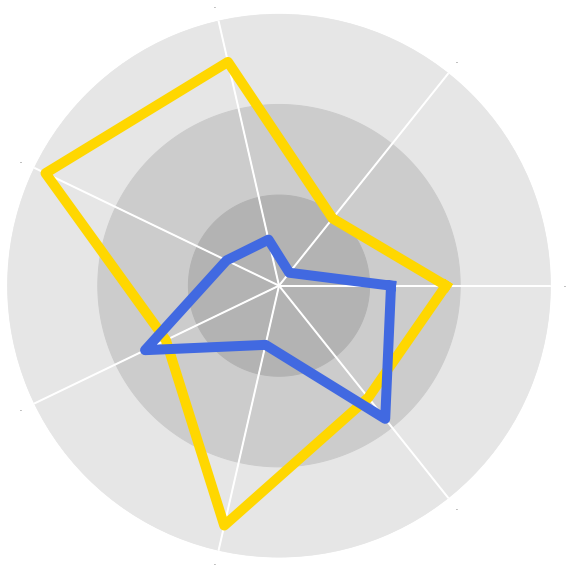

In [29]:
fig = make_spider_rvalues(dfC, 'var1', 'var2')

#fig.savefig('../figures/G2_fus_spyder_ldg.svg', dpi=300)

# projections of G2 (fc) on the cortical functional connectivity

In [30]:
ddir = '../data/tout_group/'

# read-in primary and seconardy gradients (G1 & G2) for individual subfields
h1  = h5py.File(os.path.join(ddir, 'Hmean709connGradients_left.h5'), 'r');

G2_fc_LSUB = np.array(h1['gradients_'][0:1024,1])
G2_fc_LCA = np.array(h1['gradients_'][1024:1024+2048,1])
G2_fc_LDG = np.array(h1['gradients_'][1024+2048:1024+2048+1024,1])


In [31]:
r2_fc_LSUB = np.zeros((360,))
r2_fc_LCA  = np.zeros((360,))
r2_fc_LDG = np.zeros((360,))

for k in range(0, 360):
    r2_fc_LSUB[k] = np.corrcoef(fcon_LSUB.T[k,:], G2_fc_LSUB)[-1:,:-1][0,0]
    r2_fc_LCA[k]  = np.corrcoef(fcon_LCA.T[k,:], G2_fc_LCA)[-1:,:-1][0,0]
    r2_fc_LDG[k]  = np.corrcoef(fcon_LDG.T[k,:], G2_fc_LDG)[-1:,:-1][0,0]

In [32]:
# map r-values to the isocortex
r2_fc_LSUB_labeled = map_to_labels(r2_fc_LSUB, labeling, mask=mymask) 
r2_fc_LSUB_labeled[np.where(mymask == False)] = np.nan

r2_fc_LCA_labeled = map_to_labels(r2_fc_LCA, labeling, mask=mymask) 
r2_fc_LCA_labeled[np.where(mymask == False)] = np.nan


r2_fc_LDG_labeled = map_to_labels(r2_fc_LDG, labeling, mask=mymask) 
r2_fc_LDG_labeled[np.where(mymask == False)] = np.nan


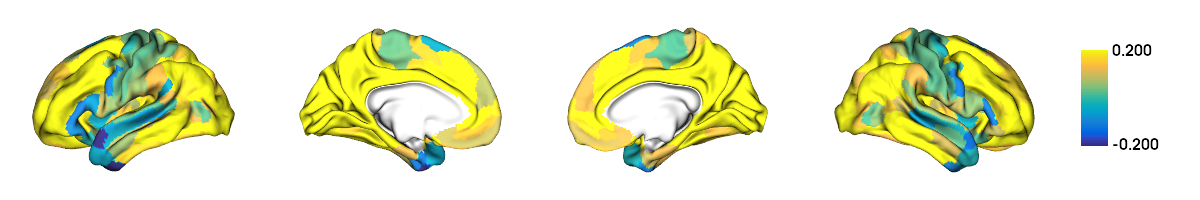

In [33]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r2_fc_LSUB_labeled,
                 nan_color = (0.9,0.9,0.9,1), size = (1200, 200), cmap = plot_funcs.parula_cmap(),
                 color_bar = True, color_range = (-0.2, 0.2),
                 interactive = False, zoom = 1.3, embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/fc_G2_cortex_lsub.svg'
                 )

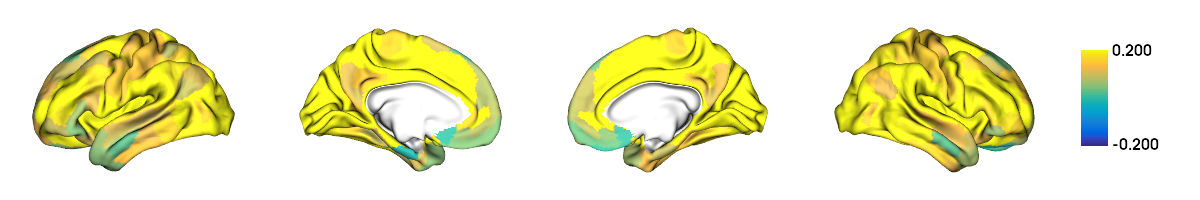

In [34]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r2_fc_LCA_labeled,
                 nan_color = (0.9,0.9,0.9,1), size = (1200, 200), cmap = plot_funcs.parula_cmap(),
                 color_bar = True, color_range = (-0.2, 0.2),
                 interactive = False, zoom = 1.3, embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/fc_G2_cortex_lca.svg'
                 )

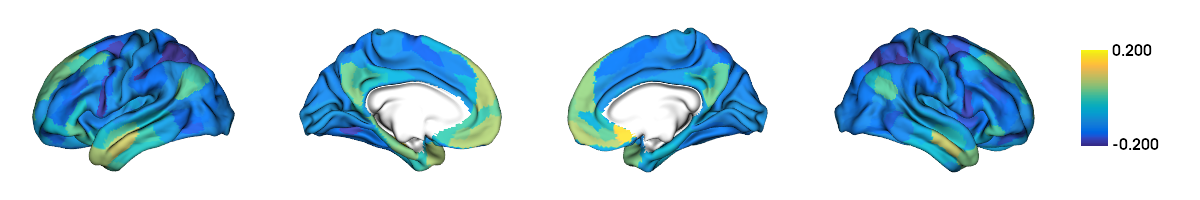

In [35]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r2_fc_LDG_labeled,
                 nan_color = (0.9,0.9,0.9,1), size = (1200, 200), cmap = plot_funcs.parula_cmap(),
                 color_bar = True, color_range = (-0.2, 0.2),
                 interactive = False, zoom = 1.3, embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/fc_G2_cortex_ldg.svg'
                 )

# projections of G2 (sic) on the cortical functional connectivity

In [36]:
outdir = '../data/tout_group/'

h = h5py.File(os.path.join(outdir, 'Hmean709scovGradients_left.h5'), 'r')
data = np.array(h['data']).T

G2_sic_LSUB = data[0:1024,1]
G2_sic_LCA  = data[1024:1024+2048,1]
G2_sic_LDG  = data[1024+2048:1024+2048+1024,1] 


In [37]:
r2_sic_LSUB = np.zeros((360,))
r2_sic_LCA  = np.zeros((360,))
r2_sic_LDG = np.zeros((360,))

for k in range(0, 360):
    r2_sic_LSUB[k] = np.corrcoef(fcon_LSUB.T[k,:], G2_sic_LSUB)[-1:,:-1][0,0]
    r2_sic_LCA[k]  = np.corrcoef(fcon_LCA.T[k,:], G2_sic_LCA)[-1:,:-1][0,0]
    r2_sic_LDG[k]  = np.corrcoef(fcon_LDG.T[k,:], G2_sic_LDG)[-1:,:-1][0,0]
    
# map r-values to the isocortex
r2_sic_LSUB_labeled = map_to_labels(r2_sic_LSUB, labeling, mask=mymask) 
r2_sic_LSUB_labeled[np.where(mymask == False)] = np.nan

r2_sic_LCA_labeled = map_to_labels(r2_sic_LCA, labeling, mask=mymask) 
r2_sic_LCA_labeled[np.where(mymask == False)] = np.nan

r2_sic_LDG_labeled = map_to_labels(r2_sic_LDG, labeling, mask=mymask) 
r2_sic_LDG_labeled[np.where(mymask == False)] = np.nan

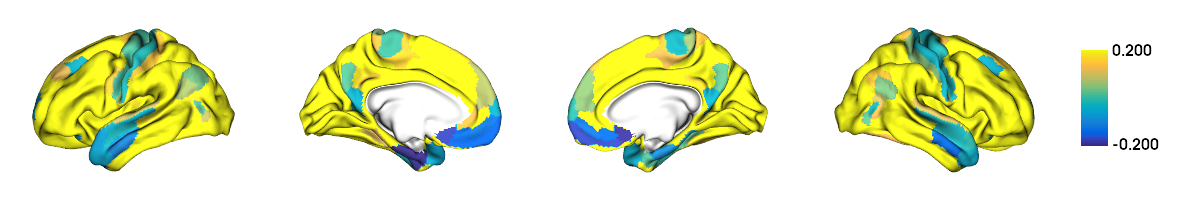

In [38]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r2_sic_LSUB_labeled,
                 nan_color = (0.9,0.9,0.9,1), size = (1200, 200), cmap = plot_funcs.parula_cmap(),
                 color_bar = True, color_range = (-0.2, 0.2),
                 interactive = False, zoom = 1.3, embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/sic_G2_cortex_lsub.svg'                   
                )

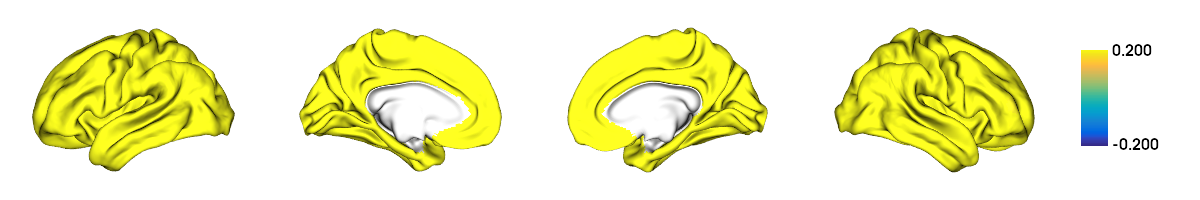

In [39]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r2_sic_LCA_labeled,
                 nan_color = (0.9,0.9,0.9,1), size = (1200, 200), cmap = plot_funcs.parula_cmap(),
                 color_bar = True, color_range = (-0.2, 0.2),
                 interactive = False, zoom = 1.3, embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/sic_G2_cortex_lca.svg'                   
                )

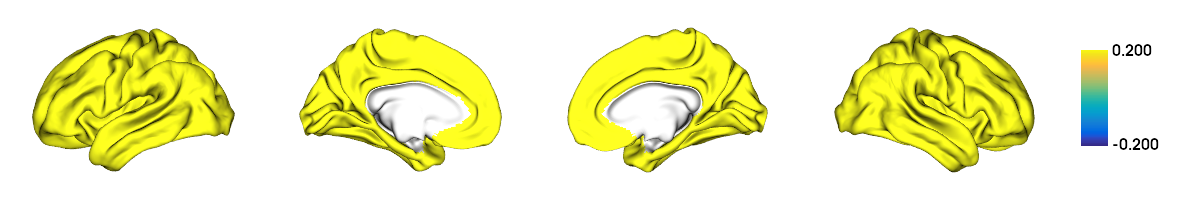

In [40]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r2_sic_LDG_labeled,
                 nan_color = (0.9,0.9,0.9,1), size = (1200, 200), cmap = plot_funcs.parula_cmap(),
                 color_bar = True, color_range = (-0.2, 0.2),
                 interactive = False, zoom = 1.3, embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/sic_G2_cortex_ldg.svg'                   
                )

# projections of G2 (gen) on the cortical functional connectivity

In [41]:
g = h5py.File(os.path.join(outdir, 'Hmean709genGradients_left.h5'), 'r')
data = np.array(g['data']).T

G2_gen_LSUB = data[0:1024,1]
G2_gen_LCA  = data[1024:1024+2048,1]
G2_gen_LDG  = data[1024+2048:1024+2048+1024,1] 


In [42]:
r2_gen_LSUB = np.zeros((360,))
r2_gen_LCA  = np.zeros((360,))
r2_gen_LDG = np.zeros((360,))

for k in range(0, 360):
    r2_gen_LSUB[k] = np.corrcoef(fcon_LSUB.T[k,:], G2_gen_LSUB)[-1:,:-1][0,0]
    r2_gen_LCA[k]  = np.corrcoef(fcon_LCA.T[k,:], G2_gen_LCA)[-1:,:-1][0,0]
    r2_gen_LDG[k]  = np.corrcoef(fcon_LDG.T[k,:], G2_gen_LDG)[-1:,:-1][0,0]
    
# map r-values to the isocortex
r2_gen_LSUB_labeled = map_to_labels(r2_gen_LSUB, labeling, mask=mymask) 
r2_gen_LSUB_labeled[np.where(mymask == False)] = np.nan

r2_gen_LCA_labeled = map_to_labels(r2_gen_LCA, labeling, mask=mymask) 
r2_gen_LCA_labeled[np.where(mymask == False)] = np.nan

r2_gen_LDG_labeled = map_to_labels(r2_gen_LDG, labeling, mask=mymask) 
r2_gen_LDG_labeled[np.where(mymask == False)] = np.nan

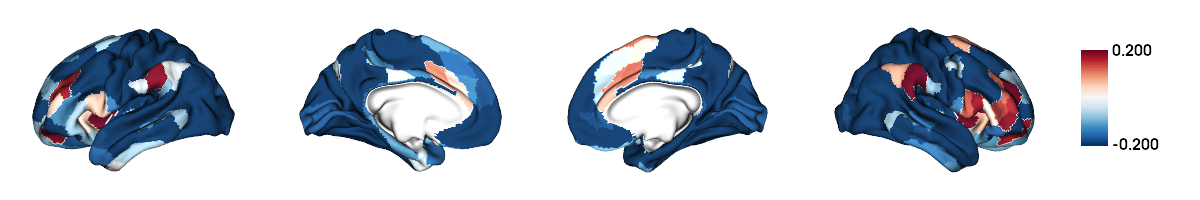

In [43]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r2_gen_LSUB_labeled,
                 nan_color = (0.9,0.9,0.9,1), size = (1200, 200), cmap = 'RdBu_r',
                 color_bar = True, color_range = (-0.2, 0.2),
                 interactive = False, zoom = 1.3, embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/gen_G2_cortex_lsub.svg'                   
                )

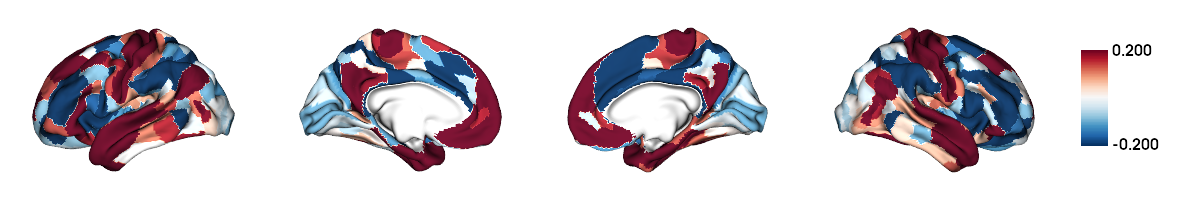

In [44]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r2_gen_LCA_labeled,
                 nan_color = (0.9,0.9,0.9,1), size = (1200, 200), cmap = 'RdBu_r',
                 color_bar = True, color_range = (-0.2, 0.2),
                 interactive = False, zoom = 1.3, embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/gen_G2_cortex_lca.svg'                   
                )

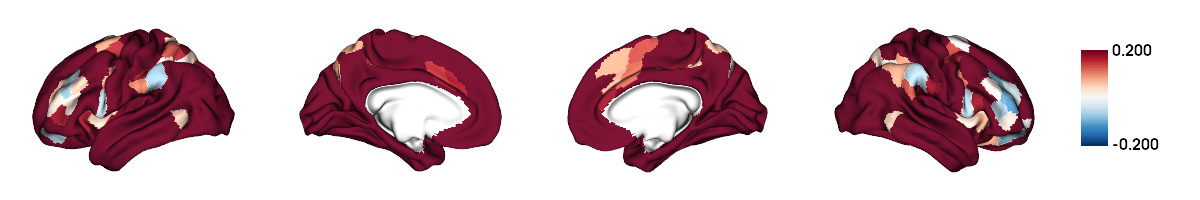

In [45]:
plot_hemispheres(surf_lh, surf_rh, 
                 array_name = r2_gen_LDG_labeled,
                 nan_color = (0.9,0.9,0.9,1), size = (1200, 200), cmap = 'RdBu_r',
                 color_bar = True, color_range = (-0.2, 0.2),
                 interactive = False, zoom = 1.3, embed_nb = True,
                 #screenshot = True,
                 #filename = '../figures/gen_G2_cortex_lg.svg'                   
                )